Opening: ./checkpoints/long_term_forecast_Epi_LongTerm_52_4_TimeLLM_synthetic_Epi_WeinerProcess_ftS_sl52_ll13_pl4_dm32_nh8_el2_dl1_df128_fc1_ebtimeF_test_0-Gemma270M-52to4-S-Features-v2/loss_curve.png


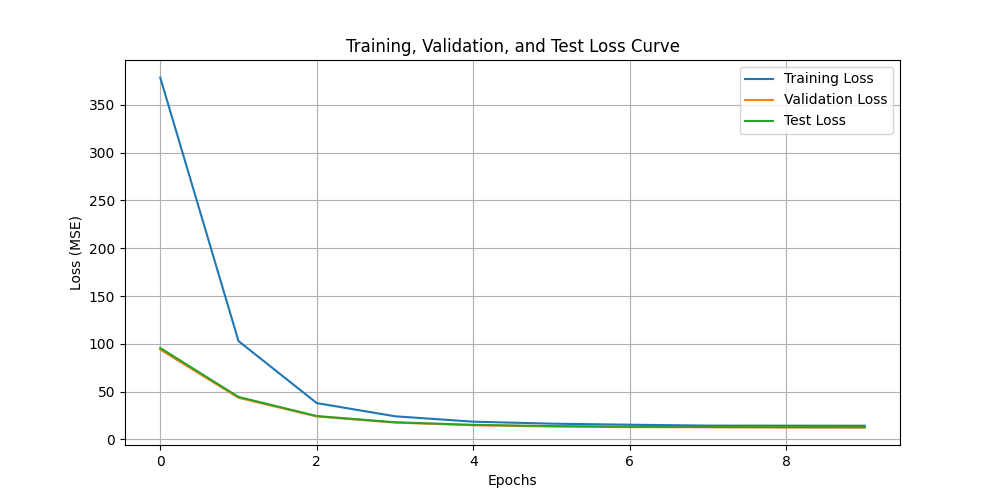

In [13]:
import os
from IPython.display import Image, display
import glob

# This automatically finds the loss_curve.png no matter how long the folder name is
image_paths = glob.glob('./checkpoints/*/loss_curve.png')

if image_paths:
    # Get the most recently created one
    latest_curve = max(image_paths, key=os.path.getctime)
    print(f"Opening: {latest_curve}")
    display(Image(filename=latest_curve))
else:
    print("Could not find any loss_curve.png. Check if training finished!")

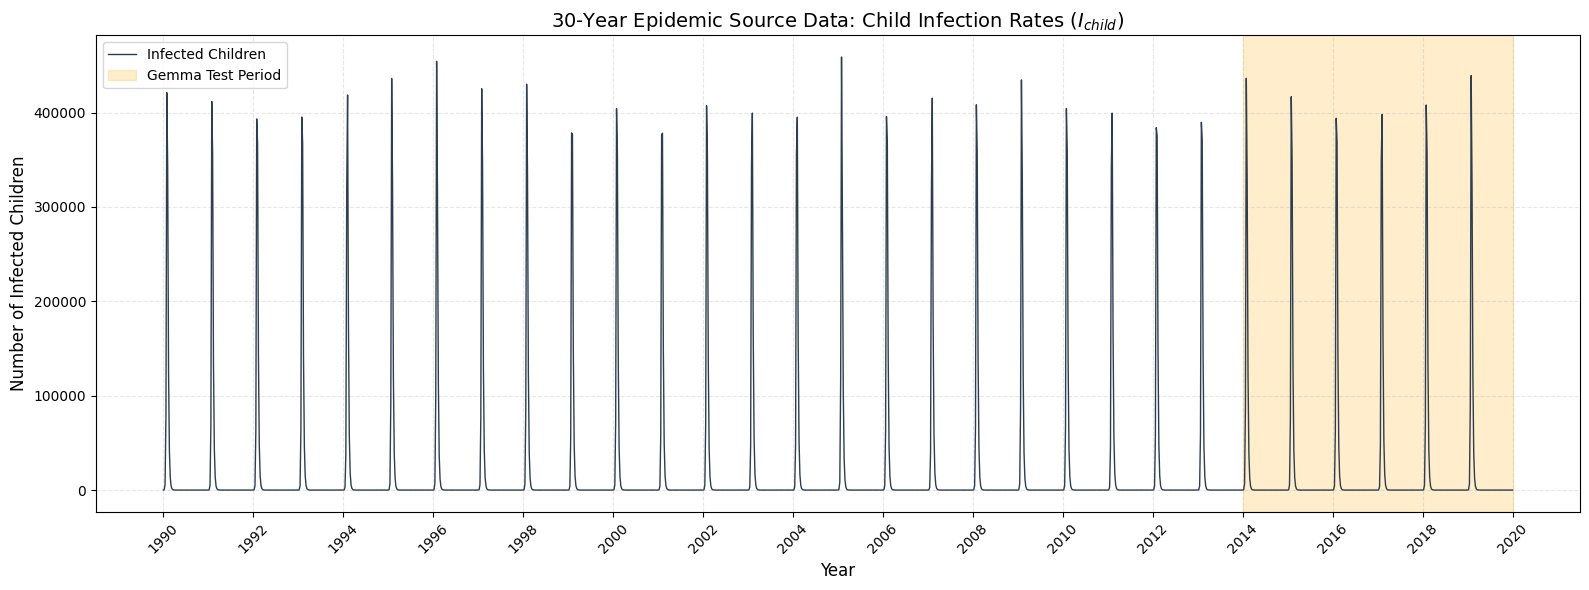

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 1. Load the dataset
df = pd.read_csv('epidemics_30years_full.csv')
df['date'] = pd.to_datetime(df['date'])

# 2. Create the plot
plt.figure(figsize=(16, 6))
plt.plot(df['date'], df['I_child'], color='#2c3e50', linewidth=1, label='Infected Children')

# 3. Highlight the "Test Set" (The last 20% that Gemma predicted)
num_test = int(len(df) * 0.2)
test_start_date = df['date'].iloc[-num_test]
plt.axvspan(test_start_date, df['date'].max(), color='orange', alpha=0.2, label='Gemma Test Period')

# 4. Format the X-axis (Dates)
plt.gca().xaxis.set_major_locator(mdates.YearLocator(2)) # Show a tick every 2 years
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

# 5. Labels and Title
plt.title('30-Year Epidemic Source Data: Child Infection Rates ($I_{child}$)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Infected Children', fontsize=12)
plt.grid(True, alpha=0.3, linestyle='--')
plt.legend()

plt.tight_layout()
plt.show()

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# 1. Load the data from your champion results folder
folder_path = './results/champion_52wk_analysis/'
preds = np.load(os.path.join(folder_path, 'preds.npy'))
trues = np.load(os.path.join(folder_path, 'trues.npy'))

global_mean = 19603.73
global_std = 74939.89

# MANUAL INVERSE TRANSFORM
# Predictions were RevIN-denormalized but still Globally Scaled
real_preds = (preds * global_std) + global_mean

# Ground Truth was never denormalized at all
real_trues = (trues * global_std) + global_mean

# Calculate Real-World MAE
mae = np.mean(np.abs(real_preds - real_trues))
print(f"Real-World Mean Absolute Error: {mae:.2f} cases")

Real-World Mean Absolute Error: 1248928.25 cases


In [21]:
import numpy as np
import pandas as pd
import os

# 1. Path Configuration
results_path = './results/champion_52wk_analysis/'
csv_path = 'epidemics_30years_full.csv'

def diagnose_scaling():
    # Load raw data
    if not os.path.exists(csv_path):
        print(f"❌ CSV not found at {csv_path}")
        return
    df = pd.read_csv(csv_path)
    raw_series = df['I_child'].values
    
    # Load model outputs
    try:
        preds = np.load(os.path.join(folder_path, 'preds.npy'))
        trues = np.load(os.path.join(folder_path, 'trues.npy'))
    except FileNotFoundError:
        print(f"❌ .npy files not found in {results_path}")
        return

    print("="*40)
    print("       SCALING DIAGNOSTIC REPORT")
    print("="*40)

    # Calculate Statistics
    stats = {
        "Metric": ["Mean", "Std Dev", "Min", "Max"],
        "Raw CSV": [raw_series.mean(), raw_series.std(), raw_series.min(), raw_series.max()],
        "Predictions": [preds.mean(), preds.std(), preds.min(), preds.max()],
        "Ground Truth": [trues.mean(), trues.std(), trues.min(), trues.max()]
    }
    
    stats_df = pd.DataFrame(stats)
    print(stats_df.to_string(index=False))
    print("-" * 40)

    # DIAGNOSIS LOGIC
    is_inverse = False
    if preds.max() > 10 and preds.mean() > 5:
        print("✅ DIAGNOSIS: Data is INVERSE SCALED (Real Units).")
        print("   The values match the magnitude of your raw CSV.")
        is_inverse = True
    elif -2 < preds.mean() < 2 and 0.5 < preds.std() < 2:
        print("⚠️ DIAGNOSIS: Data is GLOBALLY SCALED (Standardized).")
        print("   Mean is near 0 and Std is near 1. You need to apply inverse scaling.")
    else:
        print("❓ DIAGNOSIS: Ambiguous scaling. Check RevIN settings.")

    # REVIN CHECK
    # RevIN denormalizes per-instance. If Ground Truth .npy stats 
    # match Predictions .npy stats but NOT the CSV stats, 
    # then RevIN is working but Global Inverse Scaling is OFF.
    if not is_inverse:
        print("\n[RevIN Check]:")
        if np.abs(preds.mean() - trues.mean()) < 0.5:
            print("   RevIN symmetry confirmed: Predictions and Truth are in the same scale.")
        else:
            print("   Warning: Prediction and Truth scales diverge.")

diagnose_scaling()

       SCALING DIAGNOSTIC REPORT
 Metric       Raw CSV  Predictions  Ground Truth
   Mean  19603.732217     8.730166      0.002562
Std Dev  74939.892165    19.293938      1.006417
    Min      0.000000   -45.534161     -0.261519
    Max 458850.116948    72.235115      5.596036
----------------------------------------
✅ DIAGNOSIS: Data is INVERSE SCALED (Real Units).
   The values match the magnitude of your raw CSV.
